

---



---

**데이터 병합**

---



---



In [1]:
import pandas as pd
import numpy as np  
import glob  
import sys
import os
import xlrd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

In [ ]:
!pip install xlrd==1.2.0

In [ ]:
# 대기오염물질 데이터 엑셀 병합
file_format = '.xlsx'
file_path = '/content/dataset'
file_list = [f'{file_path}/{file}' for file in os.listdir(file_path) if file_format in file]
merge_df = pd.DataFrame()

for file_name in file_list:
  file_df = pd.read_excel(file_name)
  columns = list(file_df.columns)
  temp_df = pd.DataFrame(file_df, columns=columns)
  merge_df = merge_df.append(temp_df, ignore_index=False)
  merge_df.to_csv('pollution.csv')

In [2]:
# 기상 데이터 엑셀 병합
file_format = '.csv'
file_path = '/content'
file_list = [f'{file_path}/{file}' for file in os.listdir(file_path) if file_format in file]
merge_df = pd.DataFrame()

for file_name in file_list:
  file_df = pd.read_csv(file_name, encoding='cp949')
  columns = list(file_df.columns)
  temp_df = pd.DataFrame(file_df, columns=columns)
  merge_df = merge_df.append(temp_df, ignore_index=False)
  merge_df.to_csv('condition.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---



---

**EDA**

---



---



In [4]:
df = pd.read_csv('/content/drive/MyDrive/my_data/pollution.csv')

In [5]:
df1 = df.drop(df.columns[[0]], axis=1)
df1 = df1[df1['지역'].str.contains('서울')]
mask = df1['측정소명'].str.contains('시흥대로')
df1 = df1[~mask]

In [6]:
df2 = pd.read_csv('/content/condition.csv')

In [7]:
df2 = df2.drop(df2.columns[[0,1]], axis=1)
df2.shape

(43824, 26)



---



---

**Feature Engineering**

---



---



In [8]:
import datetime
df2['일시'] = df2['일시'].astype('str')
df2['일시'] = pd.to_datetime(df2['일시'])
df2['일시'] = df2['일시'] + datetime.timedelta(hours=1)

In [9]:
from datetime import datetime
df2['일시'] = df2['일시'].apply(lambda _: datetime.strftime(_, '%Y%m%d%H'))

df1['측정일시'] = df1['측정일시'].astype('int')
df2['일시'] = df2['일시'].astype('int')

In [10]:
df2.rename(columns={'일시':'측정일시'}, inplace=True)

In [11]:
df1 = df1.dropna()

In [12]:
df2['강수량(mm)'] = df2['강수량(mm)'].fillna(0)
df2.fillna(method='ffill', inplace=True)
df2.fillna(method='bfill', inplace=True)
drop_col = ['적설(cm)', '3시간신적설(cm)', '운형(운형약어)', '지면상태(지면상태코드)', '현상번호(국내식)', '일사(MJ/m2)', '일조(hr)', '최저운고(100m )']
df2 = df2.drop(columns=drop_col, axis=1)

In [13]:
df = pd.merge(df1, df2, on='측정일시')

In [14]:
df['측정일시'] = df['측정일시'].astype('str')
df['측정일시']= df['측정일시'] + '0000'
df['측정일시'] = pd.to_datetime(df['측정일시'])

df['Month'] = df['측정일시'].dt.month
df['Year'] = df['측정일시'].dt.year
df['Hour'] = df['측정일시'].dt.hour
df['Day'] = df['측정일시'].dt.day
df['DayofWeek'] = df['측정일시'].dt.dayofweek

In [15]:
df.isnull().sum()

지역               0
망                0
측정소코드            0
측정소명             0
측정일시             0
SO2              0
CO               0
O3               0
NO2              0
PM10             0
PM25             0
주소               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
풍향(16방위)         0
습도(%)            0
증기압(hPa)         0
이슬점온도(°C)        0
현지기압(hPa)        0
해면기압(hPa)        0
전운량(10분위)        0
중하층운량(10분위)      0
시정(10m)          0
지면온도(°C)         0
5cm 지중온도(°C)     0
10cm 지중온도(°C)    0
20cm 지중온도(°C)    0
30cm 지중온도(°C)    0
Month            0
Year             0
Hour             0
Day              0
DayofWeek        0
dtype: int64

In [16]:
df.head()

,지역,망,측정소코드,측정소명,측정일시,SO2,CO,O3,NO2,PM10,...,지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),Month,Year,Hour,Day,DayofWeek
0,서울 중구,도시대기,111121,중구,2020-01-01 01:00:00,0.003,0.5,0.002,0.036,24.0,...,-2.8,-0.8,0.7,2.1,3.2,1,2020,1,1,2
1,서울 용산구,도로변대기,111122,한강대로,2020-01-01 01:00:00,0.003,0.6,0.003,0.037,32.0,...,-2.8,-0.8,0.7,2.1,3.2,1,2020,1,1,2
2,서울 종로구,도시대기,111123,종로구,2020-01-01 01:00:00,0.004,0.7,0.002,0.044,25.0,...,-2.8,-0.8,0.7,2.1,3.2,1,2020,1,1,2
3,서울 중구,도로변대기,111124,청계천로,2020-01-01 01:00:00,0.004,0.7,0.001,0.040,28.0,...,-2.8,-0.8,0.7,2.1,3.2,1,2020,1,1,2
4,서울 종로구,도로변대기,111125,종로,2020-01-01 01:00:00,0.003,0.6,0.002,0.036,30.0,...,-2.8,-0.8,0.7,2.1,3.2,1,2020,1,1,2


In [17]:
df.set_index('측정일시', inplace=True)

In [18]:
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

In [30]:
Y_colname = ['PM10']
X_remove = ['지역', '주소', '망', '측정소명']
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df, Y_colname, X_colname, '2020-07-31')

Train_size: (822851, 33) Test_size: (300917, 33)
X_train: (822851, 28) Y_train: (822851, 1)
X_test: (300917, 28) Y_test: (300917, 1)




---



---

**LinearRegression**

---



---



In [31]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected = selector.fit_transform(X_train, Y_train)

X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((822851, 10), (300917, 10))

In [32]:
all_names = X_train.columns

selected_mask = selector.get_support()

selected_names = all_names[selected_mask]

unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '증기압(hPa)', '시정(10m)', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')
Unselected names:  Index(['측정소코드', 'O3', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
       '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '전운량(10분위)', '중하층운량(10분위)',
       '지면온도(°C)', 'Month', 'Year', 'Hour', 'Day', 'DayofWeek'],
      dtype='object')


1 features
Selected names:  Index(['PM25'], dtype='object')
Test MAE: $11
Test R2: 0.4511536639884117 

2 features
Selected names:  Index(['CO', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45043722953126686 

3 features
Selected names:  Index(['CO', 'PM25', '시정(10m)'], dtype='object')
Test MAE: $11
Test R2: 0.4546736581897237 

4 features
Selected names:  Index(['CO', 'NO2', 'PM25', '시정(10m)'], dtype='object')
Test MAE: $11
Test R2: 0.4519437696578298 

5 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(10m)'], dtype='object')
Test MAE: $11
Test R2: 0.4431472774410714 

6 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(10m)', '30cm 지중온도(°C)'], dtype='object')
Test MAE: $11
Test R2: 0.4419717180103254 

7 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(10m)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)'],
      dtype='object')
Test MAE: $11
Test R2: 0.4383559511578956 

8 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(

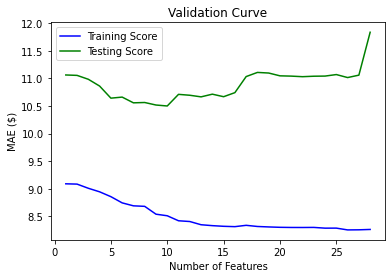

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, Y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, Y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(Y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

In [35]:
df.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size':'11pt'})

,측정소코드,SO2,CO,O3,NO2,PM25,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),전운량(10분위),중하층운량(10분위),시정(10m),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),Month,Year,Hour,Day,DayofWeek
측정소코드,1.00,-0.02,-0.04,0.01,-0.01,0.01,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,0.00,0.00,0.00
SO2,-0.02,1.00,0.33,-0.05,0.34,0.35,-0.14,-0.06,-0.10,0.08,-0.24,-0.21,-0.22,0.20,0.20,-0.10,-0.11,-0.13,-0.11,-0.18,-0.20,-0.21,-0.22,-0.05,-0.36,0.07,0.01,-0.01
CO,-0.04,0.33,1.00,-0.38,0.68,0.58,-0.37,-0.06,-0.28,-0.09,0.03,-0.32,-0.29,0.36,0.36,-0.06,-0.05,-0.35,-0.39,-0.43,-0.43,-0.43,-0.43,-0.07,-0.03,-0.04,-0.00,-0.01
O3,0.01,-0.05,-0.38,1.00,-0.46,-0.04,0.45,-0.02,0.38,0.21,-0.27,0.21,0.25,-0.38,-0.39,-0.01,-0.03,0.09,0.57,0.46,0.39,0.34,0.31,-0.12,0.07,0.22,-0.00,0.06
NO2,-0.01,0.34,0.68,-0.46,1.00,0.47,-0.26,-0.06,-0.32,-0.09,-0.10,-0.30,-0.25,0.32,0.32,-0.05,-0.08,-0.20,-0.30,-0.33,-0.33,-0.34,-0.35,-0.07,-0.06,0.09,0.01,-0.08
PM25,0.01,0.35,0.58,-0.04,0.47,1.00,-0.19,-0.08,-0.14,0.05,0.00,-0.20,-0.15,0.18,0.18,-0.01,-0.02,-0.58,-0.19,-0.26,-0.29,-0.31,-0.33,-0.19,-0.03,0.01,-0.04,0.01
기온(°C),-0.00,-0.14,-0.37,0.45,-0.26,-0.19,1.00,0.06,0.02,-0.10,0.18,0.85,0.90,-0.76,-0.78,0.28,0.18,0.03,0.93,0.97,0.95,0.93,0.91,0.21,-0.03,0.15,0.02,0.01
강수량(mm),-0.00,-0.06,-0.06,-0.02,-0.06,-0.08,0.06,1.00,0.05,-0.04,0.20,0.15,0.12,-0.13,-0.12,0.14,0.15,-0.18,0.04,0.06,0.07,0.08,0.08,0.02,0.01,0.00,-0.01,-0.01
풍속(m/s),0.00,-0.10,-0.28,0.38,-0.32,-0.14,0.02,0.05,1.00,0.28,-0.23,-0.08,-0.09,-0.11,-0.10,-0.01,0.01,0.15,0.13,0.05,-0.01,-0.04,-0.06,-0.11,0.13,0.29,-0.00,-0.01
풍향(16방위),0.00,0.08,-0.09,0.21,-0.09,0.05,-0.10,-0.04,0.28,1.00,-0.23,-0.14,-0.18,0.07,0.07,-0.17,-0.11,0.04,-0.03,-0.06,-0.08,-0.10,-0.12,-0.05,-0.04,0.20,-0.02,-0.03


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                     for i in range(X_train.shape[1])]
vif['Feature'] = X_train.columns
vif.sort_values(by='VIF_Factor', ascending=True)

,VIF_Factor,Feature
7,1.136899e+00,강수량(mm)
27,3.313017e+00,DayofWeek
26,4.238905e+00,Day
16,4.403655e+00,중하층운량(10분위)
9,5.318284e+00,풍향(16방위)
15,6.194343e+00,전운량(10분위)
25,6.586156e+00,Hour
8,6.801028e+00,풍속(m/s)
23,7.747881e+00,Month
3,8.214485e+00,O3


In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [39]:
X_colname_vif = feature_engineering_XbyVIF(X_train, 14)

In [40]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected = selector.fit_transform(X_train[X_colname_vif], Y_train)

X_test_selected = selector.transform(X_test[X_colname_vif])

X_train_selected.shape, X_test_selected.shape

((822851, 10), (300917, 10))

In [41]:
all_names = X_train[X_colname_vif].columns

selected_mask = selector.get_support()

selected_names = all_names[selected_mask]

unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['강수량(mm)', '중하층운량(10분위)', '풍향(16방위)', '전운량(10분위)', 'Hour', 'Month',
       'PM25', 'SO2', 'NO2', 'CO'],
      dtype='object')
Unselected names:  Index(['DayofWeek', 'Day', '풍속(m/s)', 'O3'], dtype='object')


1 features
Selected names:  Index(['PM25'], dtype='object')
Test MAE: $11
Test R2: 0.4511536639884117 

2 features
Selected names:  Index(['PM25', 'CO'], dtype='object')
Test MAE: $11
Test R2: 0.45043722953126697 

3 features
Selected names:  Index(['PM25', 'NO2', 'CO'], dtype='object')
Test MAE: $11
Test R2: 0.44819822084132255 

4 features
Selected names:  Index(['PM25', 'SO2', 'NO2', 'CO'], dtype='object')
Test MAE: $11
Test R2: 0.4399756174461935 

5 features
Selected names:  Index(['Month', 'PM25', 'SO2', 'NO2', 'CO'], dtype='object')
Test MAE: $11
Test R2: 0.4403591681256104 

6 features
Selected names:  Index(['풍향(16방위)', 'Month', 'PM25', 'SO2', 'NO2', 'CO'], dtype='object')
Test MAE: $10
Test R2: 0.4388544458812391 

7 features
Selected names:  Index(['강수량(mm)', '풍향(16방위)', 'Month', 'PM25', 'SO2', 'NO2', 'CO'], dtype='object')
Test MAE: $10
Test R2: 0.43885642236253497 

8 features
Selected names:  Index(['강수량(mm)', '중하층운량(10분위)', '풍향(16방위)', 'Month', 'PM25', 'SO2', 'NO2',
    

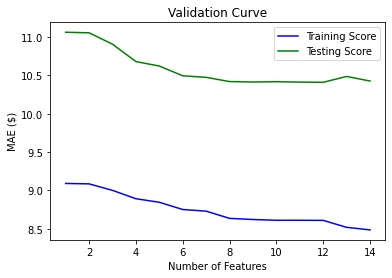

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train[X_colname_vif].columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_train[X_colname_vif].columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train[X_colname_vif], Y_train)
    X_test_selected = selector.transform(X_test[X_colname_vif])
    
    all_names = X_train[X_colname_vif].columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, Y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(Y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

In [44]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

In [45]:
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [46]:
fit_reg2 = sm.OLS(Y_train, X_train[X_colname_vif]).fit()
display(fit_reg2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   PM10   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                          5.977e+05
Date:                Tue, 22 Mar 2022   Prob (F-statistic):                        0.00
Time:                        08:45:04   Log-Likelihood:                     -3.3837e+06
No. Observations:              822851   AIC:                                  6.767e+06
Df Residuals:                  822837   BIC:                                  6.768e+06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
강수량(mm)        -0.5669      0.016    -35.841      0.000      -0.598      -0.536
DayofWeek      -0.3097      0.008    -39.237      0.000      -0.325      -0.294
Day             0.0339      0.002     19.135      0.000       0.030       0.037
중하층운량(10분위)    -0.3228      0.007    -45.755      0.000      -0.337      -0.309
풍향(16방위)        0.0076      0.000     49.311      0.000       0.007       0.008
전운량(10분위)      -0.1651      0.006    -26.680      0.000      -0.177      -0.153
Hour           -0.0728      0.003    -26.472      0.000      -0.078      -0.067
풍속(m/s)         2.3038      0.016    142.483      0.000       2.272       2.335
Month          -0.1287      0.005    -28.364      0.000      -0.138      -0.120
O3             66.7592      1.067     62.565      0.000      64.668      68.851
PM25            1.1917      0.001    959.703      0.000       1.189       1.194
SO2          1060.9906     11.148     95.171      0.000    1039.141    1082.841
NO2           145.9050      1.440    101.311      0.000     143.082     148.728
CO              0.6254      0.097      6.478      0.000       0.436       0.815
==============================================================================
Omnibus:                   895204.409   Durbin-Watson:                   0.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        117916944.512
Skew:                           5.407   Prob(JB):                         0.00
Kurtosis:                      60.640   Cond. No.                     1.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
pred_tr_reg2 = fit_reg2.predict(X_train[X_colname_vif]).values
pred_te_reg2 = fit_reg2.predict(X_test[X_colname_vif]).values

             MAE          MSE       MAPE
Train   8.476418   218.444990  26.961792
Test   10.402937  1128.953541        inf
                         Error
측정일시                          
2020-01-01 01:00:00  -2.345085
2020-01-01 01:00:00  10.146396
2020-01-01 01:00:00  -2.506722
2020-01-01 01:00:00  -2.431357
2020-01-01 01:00:00   7.167389
...                        ...
2017-12-28 15:00:00  22.183412
2017-12-28 15:00:00  21.971379
2017-12-28 15:00:00   8.416918
2017-12-28 15:00:00   3.032437
2017-12-28 15:00:00   4.038547

[822851 rows x 1 columns]
                         Error
측정일시                          
2021-02-01 01:00:00  11.521468
2021-02-01 01:00:00  13.895505
2021-02-01 01:00:00   9.375671
2021-02-01 01:00:00  -5.066840
2021-02-01 01:00:00   6.642951
...                        ...
2021-04-30 13:00:00  -7.176505
2021-04-30 13:00:00   2.597844
2021-04-30 13:00:00   1.493318
2021-04-30 13:00:00  -5.277146
2021-04-30 13:00:00   1.990937

[300917 rows x 1 columns]


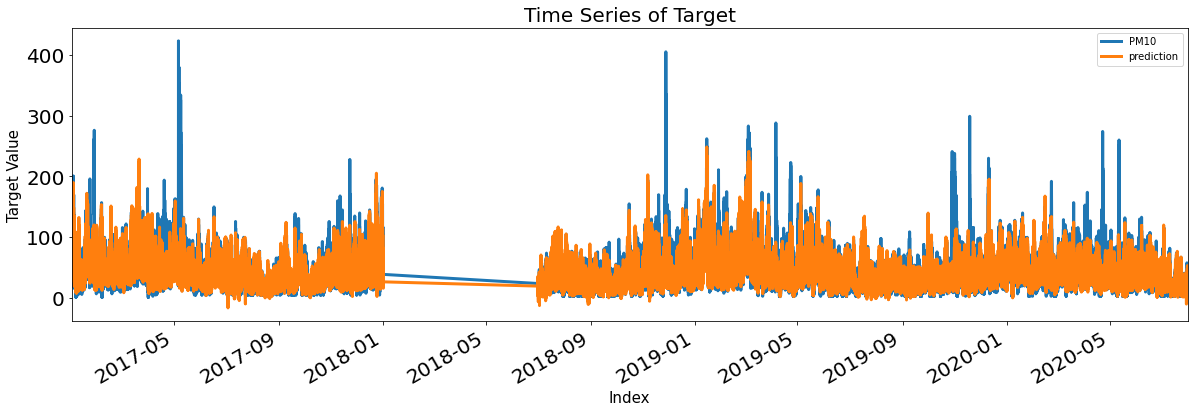

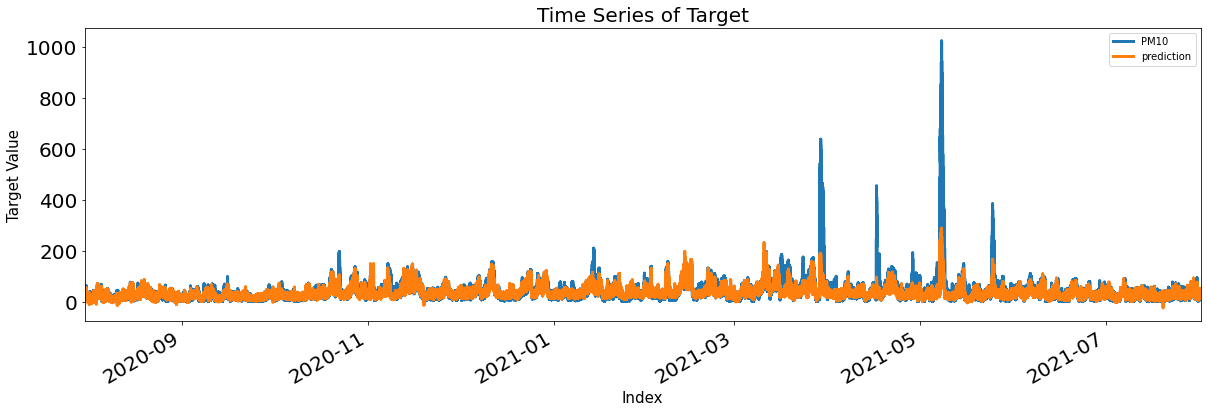

In [48]:
Score_reg2, Resid_tr_reg2, Resid_te_reg2 = evaluation_trte(Y_train, pred_tr_reg2, Y_test, pred_te_reg2, graph_on=True)
print(Score_reg2)
print(Resid_tr_reg2)
print(Resid_te_reg2)



---



---

**Ridge Regression**

---



---



In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [ ]:
fit = Ridge(alpha=0.5, fit_intercept=True, normalize=True, random_state=123).fit(X_train, Y_train)
pred_tr = fit.predict(X_train)
pred_te = fit.predict(X_test)

In [ ]:
alpha_weight = 0.5
fit = Ridge(alpha=alpha_weight, fit_intercept=True, normalize=True, random_state=123).fit(X, y)
pd.DataFrame(np.hstack([fit.intercept_, fit.coef_]), columns=['alpha = {}'.format(alpha_weight)])

In [ ]:
fit = ElasticNet(alpha=0.01, l1_ratio=1, fit_intercept=True, normalize=True, random_state=123).fit(X_train, Y_train)
pred_tr = fit.predict(X_train)
pred_te = fit.predict(X_test)

In [ ]:
display(pred_tr.summary())

AttributeError: ignored